## Problem 1: import data and plot

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

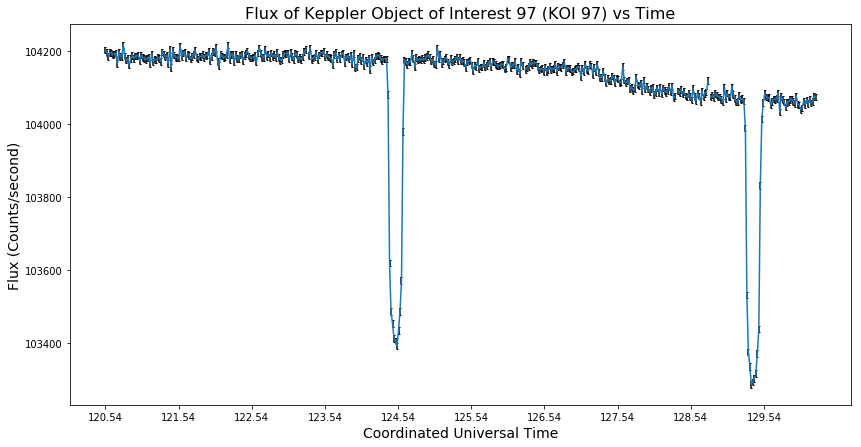

In [2]:
# import data
time, flux, flux_err = np.loadtxt('KOI97.01_1.out', unpack=True)

fig1, ax = plt.subplots(figsize = (14, 7))

ax.errorbar(x = time, y = flux,
            yerr = flux_err, fmt = '-', ecolor = 'k', capsize = 1) # cap size is size of error bars

ax.set_xlabel('Coordinated Universal Time', fontsize = 14)
plt.xticks(np.arange(min(time), max(time), 1.0))
ax.set_ylabel('Flux (Counts/second)', fontsize = 14)
ax.set_title('Flux of Keppler Object of Interest 97 (KOI 97) vs Time', fontsize = 16)

plt.show()

## Problem 2: Extract section, normalize, plot against linear fits

##### Extract data

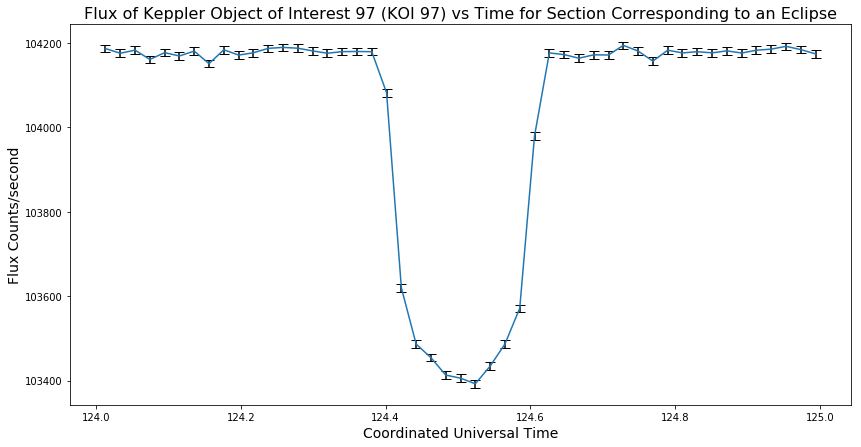

In [3]:
# Extract section that corresponds to a single eclipse (124 <= t <= 125)
eclipse_interval = np.where((time <= 125.0) & (time >= 124.0))

time_eclipse = time[eclipse_interval]
flux_eclipse = flux[eclipse_interval]
flux_err_eclipse = flux_err[eclipse_interval]

# Set up figure with subplots
fig2, ax2 = plt.subplots(figsize = (14, 7))

# Plot 1: direct from data
ax2.errorbar(x = time_eclipse, y = flux_eclipse,
            yerr = flux_err_eclipse, fmt = '-', ecolor = 'k', capsize = 5)

ax2.set_xlabel('Coordinated Universal Time', fontsize = 14)
ax2.set_ylabel('Flux Counts/second', fontsize = 14)
ax2.set_title('Flux of Keppler Object of Interest 97 (KOI 97) vs Time for Section Corresponding to an Eclipse', 
              fontsize = 16)

plt.show()

##### Linear Fit developed in Problem Set 1

In [4]:
# Linear Fit 1: part (2a)

param = {'p': 0.0858}

# Note: essentially z_fxn normalizes time
def z_fxn(time_eclipse):
    t_0 = 124.51 # t_0 is time of maximal eclipse
    tau = 0.1
    return (time_eclipse - t_0)/tau
    
z = np.array(z_fxn(time_eclipse))

# Part a) Using Flux ratio defined in PSET 1
def kappa0(z, param):
    return math.acos((param['p']**2 + z**2 - 1)/(2 * param['p'] * z))

def kappa1(z, param):
    return math.acos((1 - param['p']**2 + z**2)/(2 * z))

def lambd(z, param):
    if 1 + param['p'] < z:
        return 0
    if z <= 1 - param['p']:
        return param['p']**2
    if z <= param['p'] - 1:
        return 1
    arg = (4 * z**2 - (1 + z**2 - param['p']**2)**2)/4
    if arg >= 0:
        return (kappa0(z, param) * param['p']**2 + kappa1(z, param) - math.sqrt(arg))/math.pi
    else:
        return 0

def flux_ratio(z):
    return 1 - lambd(abs(z), param)

flux_fit1 = []

for i in z:
    flux_fit1.append(flux_ratio(i))

##### Normalized Raw Data and Linear Fit 1 plotted together

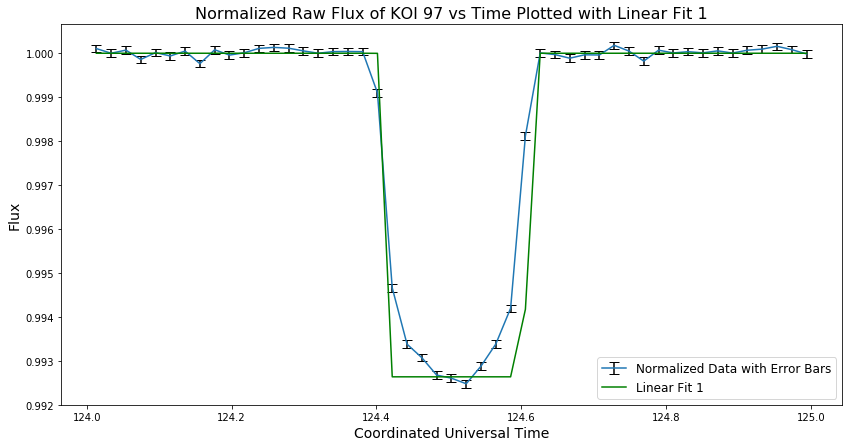

In [5]:
# Normalize Raw Data and Plot against linear fit
# p = 0.0858

# Normalize Flux and error
flux_eclipse_N = (flux_eclipse)/(flux_eclipse[1])
flux_err_eclipse_N = (flux_err[eclipse_interval])/(flux_eclipse[1])

# Set up figure with subplots
fig3, ax3 = plt.subplots(figsize = (14, 7))

# Plot 1: direct from data
ax3.errorbar(x = time_eclipse, y = flux_eclipse_N,
            yerr = flux_err_eclipse_N, fmt = '-', ecolor = 'k', capsize = 5, label = 'Normalized Data with Error Bars')

ax3.errorbar(x = time_eclipse, y = flux_fit1,
           fmt = '-', color = 'green', label = 'Linear Fit 1')

ax3.set_xlabel('Coordinated Universal Time', fontsize = 14)
ax3.set_ylabel('Flux', fontsize = 14)
ax3.set_title('Normalized Raw Flux of KOI 97 vs Time Plotted with Linear Fit 1', fontsize = 16)
ax3.legend(loc = 4, fontsize = 12)

plt.show()

##### Normalized Raw Data and Linear Fit 2: with Intensity function defined

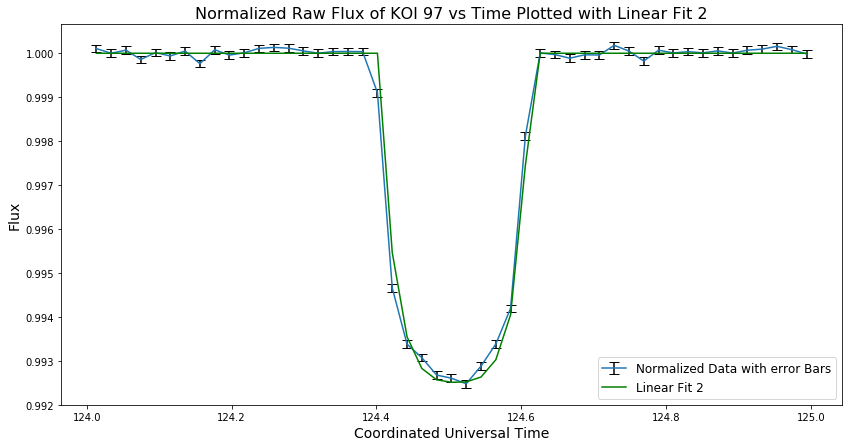

In [6]:
# Using a fit based on problem set #2 and I(r): Intensity of stellar surface 
# Note: changed size of parameters compared to Linear Fit 1
# p = 0.076

def z_fxn(time_eclipse):
    t_0 = 124.51 # t_0 is time of maximal eclipse
    tau = 0.1
    return (time_eclipse - t_0)/tau

def SimpsonInt(f, param, a, b, n):
    h = (b - a)/(n)
    sum1 = 0
    for i in range(1, n//2 + 1):
        sum1 += f(a + (2*i-1)*h, param)
        
    sum2 = 0
    for i in range(1, n//2):
        sum2 += f(a + 2*i*h, param)
        
    integral = (b-a)/(3*n)*(f(a, param) + f(b, param) + 4*sum1 + 2*sum2)
    return integral


def delta(r, param):
    if r >= param['z'] + param['p'] or r <= param['z'] - param['p']:
        return 0.0
    elif r + param['z'] <= param['p']:
        return 1.0
    else:
        return (1/(math.pi))* math.acos((param['z']**2 - param['p']**2 + r**2)/(2 * param['z'] * r))

def I(r):
    mu = math.sqrt(1 - r**2)
    return 1 - (1 - mu)**(3/2)
    
# numerator
def func1(r, param):
    return I(r)*(1 - delta(r, param)) * 2 * r

# denominator
def func2(r, param):
    return I(r)*2* r   

def flux_2(p, z):
    param = {'z': abs(z), 'p': p}
    return (SimpsonInt(func1, param, 0.0, 1.0, 10**5))/ ((SimpsonInt(func2, param, 0.0, 1.0, 10**5)))

flux_fit2 = []

for i in z:
    flux_fit2.append(flux_2(p = 0.076, z = i)) # boolean array

# Set up figure with subplots
fig4, ax4 = plt.subplots(figsize = (14, 7))

# Plot 1: direct from data
ax4.errorbar(time_eclipse, flux_eclipse_N,
            yerr = flux_err_eclipse_N, fmt = '-', ecolor = 'k', capsize = 5, label = 'Normalized Data with error Bars')

ax4.errorbar(time_eclipse,flux_fit2,
           fmt = '-', color = 'green', label = 'Linear Fit 2')

ax4.set_xlabel('Coordinated Universal Time', fontsize = 14)
ax4.set_ylabel('Flux', fontsize = 14)
ax4.set_title('Normalized Raw Flux of KOI 97 vs Time Plotted with Linear Fit 2', fontsize = 16)
ax4.legend(loc = 4, fontsize = 12)

plt.show()

Note: One side of linear is off while other looks good, is there a problem with z? Should it be another absolute value?

## Problem 3: Root Finder

##### Newton's Method

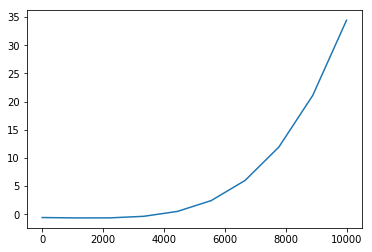

Temperature is 3947.0165083311117


In [3]:
S = 1.014 
a = 8.177 * 10**-5
b = 1.706 * 10**-9
c = 3.584 * 10**-15

def newton_root(f, df, t_0, tolerance):
    '''
    parameters:
    f: function
    df: derivative of function
    t_0: initial guess
    '''
    t = t_0
    delta = f(t)/df(t)
    while abs(delta) > tolerance:
        delta = f(t)/df(t)
        t -= delta
    print('Temperature is', t)

    

def f(t):
    return (c * t**4) - (b * (t - 5780)**2) - (a * (t - 5780)) - S

def df(t):
    return (4 * c * t**3) - (2 * b * (t - 5780)) - a

t = np.linspace(0, 10000, 10)
f_vals = list(map(f, t))
plt.plot(t, f_vals, '-')
plt.show()

approx1 = newton_root(f, df, 10000 , 10**-10)


##### Newton Method: Solution with help from Mathematical Python to double check

In [4]:
def newton(f, df, t_0, tolerance, N): 
    '''
    parameters:
    f: function
    df: derivative of function
    t_0: initial guess
    N: max number of iterations to run
    '''
    t_n = t_0
    for n in range(0, N):
        fxn = f(t_n)
        if abs(fxn) < tolerance:
            print('Found solution after',n,'iterations.')
            return t_n
        Dfxn = df(t_n)
        if Dfxn == 0:
            print('Zero derivative. No solution found.')
            return None
        t_n = t_n - fxn/Dfxn
    print('Exceeded maximum iterations. No solution found.')
    return None

approx2 = newton(f, df, 20000, 10**-10, 100)
print(approx2)

Found solution after 10 iterations.
3947.0165083311517


##### Secant Method: with help from Mathematical Python

In [84]:
def secant(f,l,u,N):
    '''
    parameters:
    f: function
    l: lower bound
    u: upper bound
    N: number of iterations to run
    '''
    if f(l)*f(u) >= 0:
        print("Secant method fails.")
        return None
    l_n = l
    u_n = u
    for n in range(1, N + 1):
        m_n = l_n - f(l_n)*(u_n - l_n)/(f(u_n) - f(l_n))
        f_m_n = f(m_n)
        if f(l_n)*f_m_n < 0:
            l_n = l_n
            u_n = m_n
        elif f(u_n)*f_m_n < 0:
            l_n = m_n
            u_n = u_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Secant method fails.")
            return None
    return l_n - f(l_n)*(u_n - l_n)/(f(u_n) - f(l_n))

approx3 = secant(f, 1, 10000, 10000)
print(approx3)

3947.0165083311103


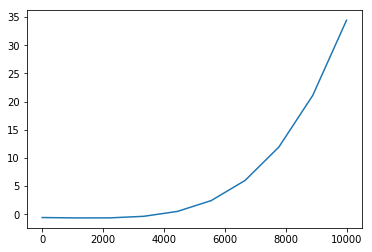

KeyboardInterrupt: 

In [10]:
S = 1.014 
a = 8.177 * 10**-5
b = 1.706 * 10**-9
c = 3.584 * 10**-15

def newton_ii(f, df, t_0, tolerance, N):
    '''
    parameters:
    f: function
    df: derivative of function
    t_0: initial guess
    '''
    t_n = t_0
    for n in range(0, N):
        delta = f(t_n)/df(t_n)
        while abs(delta) > tolerance:
            delta = f(t_n)/df(t_n)
        t -= delta
    print('Temperature is', t)
    return t
    

def f(t):
    return (c * t**4) - (b * (t - 5780)**2) - (a * (t - 5780)) - S

def df(t):
    return (4 * c * t**3) - (2 * b * (t - 5780)) - a

t = np.linspace(0, 10000, 10)
f_vals = list(map(f, t))
plt.plot(t, f_vals, '-')
plt.show()

approx1 = newton_ii(f, df, 4000 , 10**-5, 10**3)
print(approx1)